In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.layers import LSTM
from tensorflow.keras.layers import *
import plotly.graph_objects as go

In [ ]:
import os
from google.colab import drive
drive.mount('gdrive')
!ln -s "/content/gdrive/MyDrive/financial_news_project" "/content/financial_news_project"


Mounted at gdrive


In [ ]:
ticker = "AAPL"
model_name = "Inception"
seq_len = 32

In [ ]:
df = pd.read_csv("/content/financial_news_project/apple_stocks_with_frequency_of_news.csv")
df.shape

(10463, 10)

In [ ]:
df.head()

,Unnamed: 0,Date,NP,NN,Open,High,Low,Close,Adj Close,Volume
0,1740,1980-12-12,0.0,0.0,0.128348,0.128906,0.128348,0.128348,0.100178,469033600
1,1741,1980-12-15,0.0,0.0,0.122210,0.122210,0.121652,0.121652,0.094952,175884800
2,1742,1980-12-16,0.0,0.0,0.113281,0.113281,0.112723,0.112723,0.087983,105728000
3,1743,1980-12-17,0.0,0.0,0.115513,0.116071,0.115513,0.115513,0.090160,86441600
4,1744,1980-12-18,0.0,0.0,0.118862,0.119420,0.118862,0.118862,0.092774,73449600


In [ ]:
df.drop("Unnamed: 0", axis=1, inplace=True)

In [ ]:
df.head()

,Date,NP,NN,Open,High,Low,Close,Adj Close,Volume
0,1980-12-12,0.0,0.0,0.128348,0.128906,0.128348,0.128348,0.100178,469033600
1,1980-12-15,0.0,0.0,0.122210,0.122210,0.121652,0.121652,0.094952,175884800
2,1980-12-16,0.0,0.0,0.113281,0.113281,0.112723,0.112723,0.087983,105728000
3,1980-12-17,0.0,0.0,0.115513,0.116071,0.115513,0.115513,0.090160,86441600
4,1980-12-18,0.0,0.0,0.118862,0.119420,0.118862,0.118862,0.092774,73449600


In [ ]:
df.describe()

,NP,NN,Open,High,Low,Close,Adj Close,Volume
count,10463.000000,10463.000000,10463.000000,10463.000000,10463.000000,10463.000000,10463.000000,1.046300e+04
mean,1.494409,0.185415,14.701727,14.864405,14.538959,14.707347,14.073943,3.309553e+08
std,6.309480,0.802780,31.817810,32.191042,31.449022,31.833445,31.539068,3.388876e+08
min,0.000000,0.000000,0.049665,0.049665,0.049107,0.049107,0.038329,0.000000e+00
25%,0.000000,0.000000,0.283482,0.289286,0.276786,0.283482,0.235407,1.238272e+08
50%,0.000000,0.000000,0.473214,0.482143,0.464286,0.475446,0.391934,2.182656e+08
75%,0.000000,0.000000,14.795536,15.008036,14.620536,14.766964,12.764791,4.108580e+08
max,114.000000,30.000000,182.630005,182.940002,179.119995,182.009995,181.511703,7.421641e+09


In [ ]:
df[(df.Volume == 0)]

,Date,NP,NN,Open,High,Low,Close,Adj Close,Volume
165,1981-08-10,0.0,0.0,0.112723,0.112723,0.112723,0.112723,0.087983,0


In [ ]:
df.loc[165, 'Volume'] = 9206400

In [ ]:
df.shape

(10463, 9)

In [ ]:
df = df[((df.index > 7900) & (df.index < 9900))]

In [ ]:
df = df[['Date', 'Open', 'High', 'Low', 'Close', 'Volume','NN', 'NP']]
df.columns=['Date', 'open', 'high', 'low', 'close', 'volume','NN', 'NP']

In [ ]:
min_return = df[['open', 'high', 'low', 'close', 'volume','NN', 'NP']].min(axis=0)
max_return = df[['open', 'high', 'low', 'close', 'volume','NN', 'NP']].max(axis=0)

In [ ]:
df['open'] = (df['open'] - min_return['open']) / (max_return['open'] - min_return['open'])
df['high'] = (df['high'] - min_return['high']) / (max_return['high'] - min_return['high'])
df['low'] = (df['low'] - min_return['low']) / (max_return['low'] - min_return['low'])
df['close'] = (df['close'] - min_return['close']) / (max_return['close'] - min_return['close'])
df['volume'] = (df['volume'] - min_return['volume']) / (max_return['volume'] - min_return['volume'])
df['NN'] = (df['NN'] - min_return['NN']) / (max_return['NN'] - min_return['NN'])
df['NP'] = (df['NP'] - min_return['NP']) / (max_return['NP'] - min_return['NP'])
# df['diff'] = df['NP'] - df['NN']

In [ ]:
df.loc[df['NN'] < 0.18, 'NN'] = 0
df['NN'] = df['NN'] * 0.4

In [ ]:
df.loc[df['NP'] < 0.1, 'NP'] = 0
df['NP'] = df['NP'] * 0.1

In [ ]:
df.shape

(10463, 8)

In [ ]:
times = sorted(df.index.values)
last_10pct = sorted(df.index.values)[-int(0.1*len(times))]
last_20pct = sorted(df.index.values)[-int(0.2*len(times))]

df_train = df[(df.index < last_20pct)]
df_val = df[(df.index >= last_20pct) & (df.index < last_10pct)]
df_test = df[(df.index >= last_10pct)]

In [ ]:
df.head()

,open,high,low,close,volume,NN,NP
7901,0.126331,0.126752,0.127878,0.129325,0.390057,0.0,0.0
7902,0.133651,0.128947,0.128251,0.125224,0.596492,0.0,0.0
7903,0.131672,0.125185,0.126835,0.124045,0.460057,0.0,0.0
7904,0.125731,0.122262,0.125323,0.122240,0.401927,0.0,0.0
7905,0.125259,0.118764,0.116278,0.113008,0.575240,0.0,0.0


In [ ]:
df.describe()

,open,high,low,close,volume,NN,NP
count,1999.000000,1999.000000,1999.000000,1999.000000,1999.000000,1999.000000,1999.000000
mean,0.288761,0.285709,0.286830,0.285429,0.127657,0.001914,0.004191
std,0.211907,0.213326,0.210862,0.210966,0.121688,0.016489,0.011700
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.131200,0.127319,0.129542,0.128359,0.045012,0.000000,0.000000
50%,0.224665,0.220355,0.222988,0.220441,0.085648,0.000000,0.000000
75%,0.430817,0.427953,0.428086,0.425445,0.167580,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,0.400000,0.100000


In [ ]:
fig = go.Figure(go.Scatter(
    x = df_train.index,
    y = df_train['close'],
    name="Close Price Train"
))

fig.add_scatter(
    x = df.index,
    y = df['NN'],
    name="Negative"
)

fig.add_scatter(
    x = df.index,
    y = df['NP'],
    name="Positive"
)


# fig.add_scatter(
#     x = df.index,
#     y = df['NP'],
#     name="Positive"
# )
fig.add_scatter(
    x = df_val.index,
    y = df_val['close'],
    name="Close Price Validation"
)
fig.add_scatter(
    x = df_test.index,
    y = df_test['close'],
    name="Close Price Test"
)

fig.show()

In [ ]:
train_data = df_train[['close', 'high', 'low', 'open', 'volume', 'NN', 'NP']].values
val_data = df_val[['close', 'high', 'low', 'open', 'volume', 'NN', 'NP']].values
test_data = df_test[['close', 'high', 'low', 'open', 'volume', 'NN', 'NP']].values
print('Training data shape: {}'.format(train_data.shape))
print('Validation data shape: {}'.format(val_data.shape))
print('Test data shape: {}'.format(test_data.shape))

Training data shape: (1600, 7)
Validation data shape: (200, 7)
Test data shape: (199, 7)


In [ ]:
X_train, y_train = [], []
for i in range(seq_len, len(train_data)):
  X_train.append(train_data[i-seq_len:i])
  y_train.append(train_data[:, 3][i])
X_train, y_train = np.array(X_train), np.array(y_train)

###############################################################################

# Validation data
X_val, y_val = [], []
for i in range(seq_len, len(val_data)):
    X_val.append(val_data[i-seq_len:i])
    y_val.append(val_data[:, 3][i])
X_val, y_val = np.array(X_val), np.array(y_val)

###############################################################################

# Test data
X_test, y_test = [], []
for i in range(seq_len, len(test_data)):
    X_test.append(test_data[i-seq_len:i])
    y_test.append(test_data[:, 3][i])    
X_test, y_test = np.array(X_test), np.array(y_test)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)


(1568, 32, 7) (1568,)
(168, 32, 7) (168,)
(167, 32, 7) (167,)


In [ ]:
def create_model_LSTM():
  in_seq = Input(shape = (seq_len, 6))
      
  x = LSTM(128, return_sequences=True)(in_seq)
  x = LSTM(128, return_sequences=True)(x)
  x = LSTM(64, return_sequences=True)(x) 
          
  avg_pool = GlobalAveragePooling1D()(x)
  max_pool = GlobalMaxPool1D()(x)
  conc = concatenate([avg_pool, max_pool])
  conc = Dense(64, activation="relu")(conc)
  out = Dense(1, activation="linear")(conc)      

  model = tf.keras.Model(inputs=in_seq, outputs=out)
  model.compile(loss="mse", optimizer="adam", metrics=['mae', 'mape'])    
  return model

In [ ]:
def Inception_A(layer_in, c7):
  branch1x1_1 = Conv1D(c7, kernel_size=1, padding="same", use_bias=False)(layer_in)
  branch1x1 = BatchNormalization()(branch1x1_1)
  branch1x1 = ReLU()(branch1x1)
  
  branch5x5_1 = Conv1D(c7, kernel_size=1, padding='same', use_bias=False)(layer_in)
  branch5x5 = BatchNormalization()(branch5x5_1)
  branch5x5 = ReLU()(branch5x5)
  branch5x5 = Conv1D(c7, kernel_size=5, padding='same', use_bias=False)(branch5x5)
  branch5x5 = BatchNormalization()(branch5x5)
  branch5x5 = ReLU()(branch5x5)  
  
  branch3x3_1 = Conv1D(c7, kernel_size=1, padding='same', use_bias=False)(layer_in)
  branch3x3 = BatchNormalization()(branch3x3_1)
  branch3x3 = ReLU()(branch3x3)
  branch3x3 = Conv1D(c7, kernel_size=3, padding='same', use_bias=False)(branch3x3)
  branch3x3 = BatchNormalization()(branch3x3)
  branch3x3 = ReLU()(branch3x3)
  branch3x3 = Conv1D(c7, kernel_size=3, padding='same', use_bias=False)(branch3x3)
  branch3x3 = BatchNormalization()(branch3x3)
  branch3x3 = ReLU()(branch3x3) 
  
  branch_pool = AveragePooling1D(pool_size=(3), strides=1, padding='same')(layer_in)
  branch_pool = Conv1D(c7, kernel_size=1, padding='same', use_bias=False)(branch_pool)
  branch_pool = BatchNormalization()(branch_pool)
  branch_pool = ReLU()(branch_pool)
  outputs = Concatenate(axis=-1)([branch1x1, branch5x5, branch3x3, branch_pool])
  return outputs


def Inception_B(layer_in, c7):
  branch3x3 = Conv1D(c7, kernel_size=3, padding="same", strides=2, use_bias=False)(layer_in)
  branch3x3 = BatchNormalization()(branch3x3)
  branch3x3 = ReLU()(branch3x3)  
  
  branch3x3dbl = Conv1D(c7, kernel_size=1, padding="same", use_bias=False)(layer_in)
  branch3x3dbl = BatchNormalization()(branch3x3dbl)
  branch3x3dbl = ReLU()(branch3x3dbl)  
  branch3x3dbl = Conv1D(c7, kernel_size=3, padding="same", use_bias=False)(branch3x3dbl)  
  branch3x3dbl = BatchNormalization()(branch3x3dbl)
  branch3x3dbl = ReLU()(branch3x3dbl)  
  branch3x3dbl = Conv1D(c7, kernel_size=3, padding="same", strides=2, use_bias=False)(branch3x3dbl)    
  branch3x3dbl = BatchNormalization()(branch3x3dbl)
  branch3x3dbl = ReLU()(branch3x3dbl)   
  
  branch_pool = MaxPooling1D(pool_size=3, strides=2, padding="same")(layer_in)
  
  outputs = Concatenate(axis=-1)([branch3x3, branch3x3dbl, branch_pool])
  return outputs


def Inception_C(layer_in, c7):
  branch1x1_1 = Conv1D(c7, kernel_size=1, padding="same", use_bias=False)(layer_in)
  branch1x1 = BatchNormalization()(branch1x1_1)
  branch1x1 = ReLU()(branch1x1)   
  
  branch7x7_1 = Conv1D(c7, kernel_size=1, padding="same", use_bias=False)(layer_in)
  branch7x7 = BatchNormalization()(branch7x7_1)
  branch7x7 = ReLU()(branch7x7)   
  branch7x7 = Conv1D(c7, kernel_size=(7), padding="same", use_bias=False)(branch7x7)
  branch7x7 = BatchNormalization()(branch7x7)
  branch7x7 = ReLU()(branch7x7)  
  branch7x7 = Conv1D(c7, kernel_size=(1), padding="same", use_bias=False)(branch7x7)  
  branch7x7 = BatchNormalization()(branch7x7)
  branch7x7 = ReLU()(branch7x7)   

  branch7x7dbl_1 = Conv1D(c7, kernel_size=1, padding="same", use_bias=False)(layer_in)  
  branch7x7dbl = BatchNormalization()(branch7x7dbl_1)
  branch7x7dbl = ReLU()(branch7x7dbl)  
  branch7x7dbl = Conv1D(c7, kernel_size=(7), padding="same", use_bias=False)(branch7x7dbl)  
  branch7x7dbl = BatchNormalization()(branch7x7dbl)
  branch7x7dbl = ReLU()(branch7x7dbl) 
  branch7x7dbl = Conv1D(c7, kernel_size=(1), padding="same", use_bias=False)(branch7x7dbl)  
  branch7x7dbl = BatchNormalization()(branch7x7dbl)
  branch7x7dbl = ReLU()(branch7x7dbl)  
  branch7x7dbl = Conv1D(c7, kernel_size=(7), padding="same", use_bias=False)(branch7x7dbl)  
  branch7x7dbl = BatchNormalization()(branch7x7dbl)
  branch7x7dbl = ReLU()(branch7x7dbl)  
  branch7x7dbl = Conv1D(c7, kernel_size=(1), padding="same", use_bias=False)(branch7x7dbl)  
  branch7x7dbl = BatchNormalization()(branch7x7dbl)
  branch7x7dbl = ReLU()(branch7x7dbl)  
  
  branch_pool = AveragePooling1D(pool_size=3, strides=1, padding='same')(layer_in)
  branch_pool = Conv1D(c7, kernel_size=1, padding='same', use_bias=False)(branch_pool)
  branch_pool = BatchNormalization()(branch_pool)
  branch_pool = ReLU()(branch_pool)  
  
  outputs = Concatenate(axis=-1)([branch1x1, branch7x7, branch7x7dbl, branch_pool])
  return outputs

def create_model_inception():
  in_seq = Input(shape=(seq_len, 7))

  x = Inception_A(in_seq, 32)
  x = Inception_A(x, 32)
  x = Inception_B(x, 32)
  x = Inception_B(x, 32)
  x = Inception_C(x, 32)
  x = Inception_C(x, 32)    
          
  x = Bidirectional(LSTM(128, return_sequences=True))(x)
  x = Bidirectional(LSTM(128, return_sequences=True))(x)
  x = Bidirectional(LSTM(64, return_sequences=True))(x) 
          
  avg_pool = GlobalAveragePooling1D()(x)
  max_pool = GlobalMaxPooling1D()(x)
  conc = concatenate([avg_pool, max_pool])
  conc = Dense(64, activation="relu")(conc)
  out = Dense(1)(conc)      

  model = tf.keras.Model(inputs=in_seq, outputs=out)
  model.compile(loss="mse", optimizer="adam", metrics=['mae', 'mse'])     
  return model


In [ ]:
# from tensorflow import keras
# from tensorflow.keras import layers

In [ ]:

# def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
#   model = Sequential()
#   model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
#   model.add(LeakyReLU(alpha=0.2))
#   model.add(Dropout(0.4))
#   model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
#   model.add(LeakyReLU(alpha=0.2))
#   model.add(Dropout(0.4))
#   model.add(Flatten())
#   model.add(Dense(1, activation='sigmoid'))
#   # compile model
#   opt = Adam(lr=0.0002, beta_1=0.5)
#   model.compile(loss='mae', optimizer=opt, metrics=['accuracy'])
#   return model

In [ ]:
# def build_model(
#     input_shape,
#     head_size,
#     num_heads,
#     ff_dim,
#     num_transformer_blocks,
#     mlp_units,
#     dropout=0,
#     mlp_dropout=0,
# ):
#     inputs = keras.Input(shape=input_shape)
#     x = inputs
#     for _ in range(num_transformer_blocks):
#         x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

#     x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
#     for dim in mlp_units:
#         x = layers.Dense(dim, activation="relu")(x)
#         x = layers.Dropout(mlp_dropout)(x)
#     outputs = layers.Dense(1, activation="softmax")(x)
#     return keras.Model(inputs, outputs)

In [ ]:
# model = ''
# if model_name == "LSTM":
#   model = create_model_LSTM()
# else :
#   model = create_model_inception()
# callback = tf.keras.callbacks.ModelCheckpoint('/content/financial_news_project/stocks/models/common_data_sentiment_and_stocks' + model_name + '_' + ticker + '_no_sigmoid.hdf5', monitor='val_loss', save_best_only=True, verbose=1)

In [ ]:
# model.fit(X_train, y_train,
#           batch_size=32,
#           verbose=2,
#           callbacks=[callback],
#           epochs=50,
#           validation_data=(X_val, y_val),)

In [ ]:
model = tf.keras.models.load_model('/content/financial_news_project/stocks/models/common_data_sentiment_and_stocks' + model_name + '_' + ticker + '_no_sigmoid.hdf5')

In [ ]:
#Calculate predication for training, validation and test data
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)
test_pred = model.predict(X_test)

#Print evaluation metrics for all datasets
train_eval = model.evaluate(X_train, y_train, verbose=0)
val_eval = model.evaluate(X_val, y_val, verbose=0)
test_eval = model.evaluate(X_test, y_test, verbose=0)
print(' ')
print('Evaluation metrics')
print('Training Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(train_eval[0], train_eval[1], train_eval[2]))
print('Validation Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(val_eval[0], val_eval[1], val_eval[2]))
print('Test Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(test_eval[0], test_eval[1], test_eval[2]))

 
Evaluation metrics
Training Data - Loss: 0.0002, MAE: 0.0105, MAPE: 0.0002
Validation Data - Loss: 0.0019, MAE: 0.0347, MAPE: 0.0019
Test Data - Loss: 0.0582, MAE: 0.1959, MAPE: 0.0582


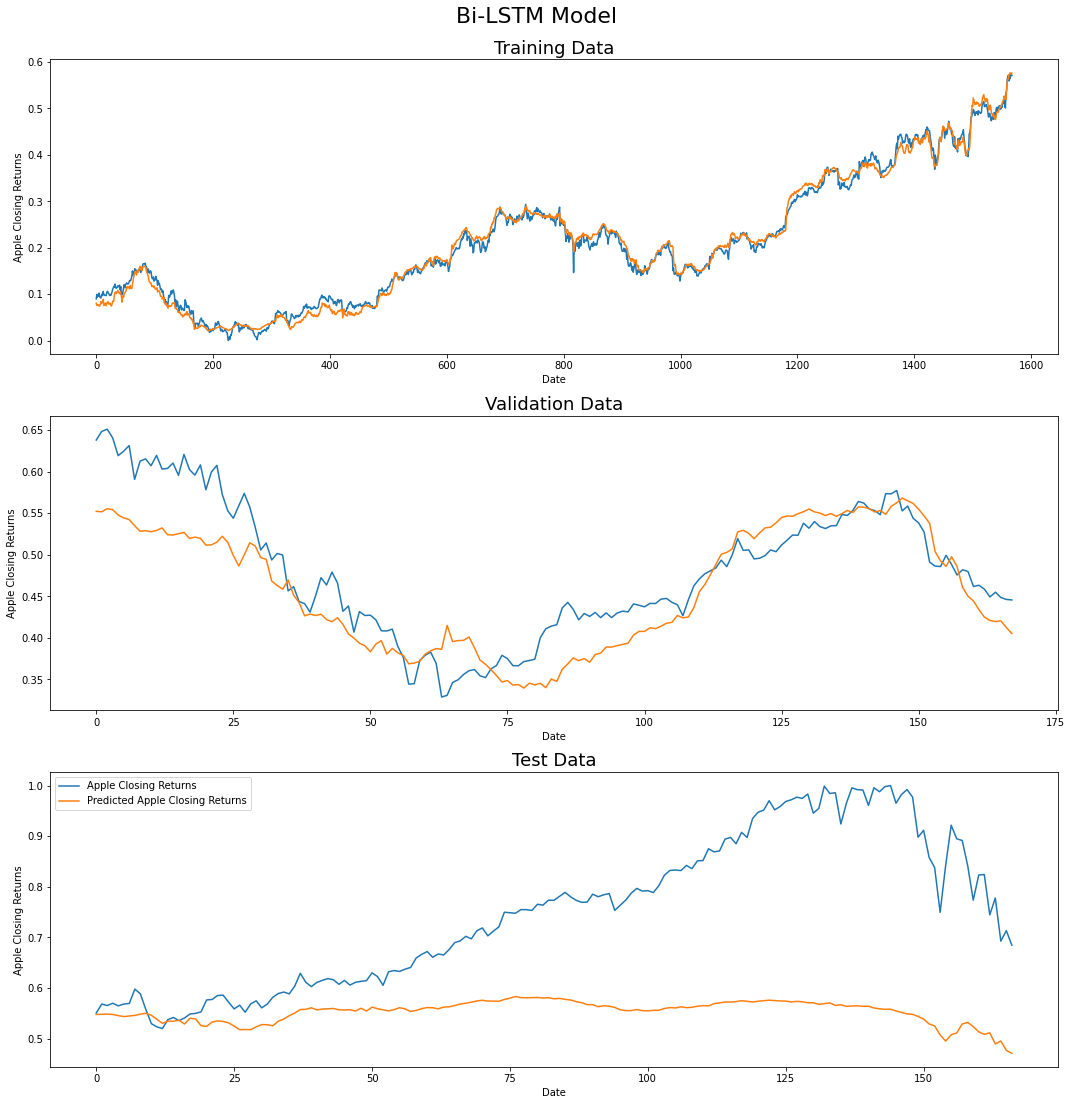

In [ ]:
fig = plt.figure(figsize=(15,15))
st = fig.suptitle("Bi-LSTM Model", fontsize=22)
st.set_y(1.02)

#Plot training data results
ax11 = fig.add_subplot(311)
ax11.plot(y_train, label='Apple Closing Returns')
ax11.plot(train_pred, label='Predicted Apple Closing Returns')
ax11.set_title("Training Data", fontsize=18)
ax11.set_xlabel('Date')
ax11.set_ylabel('Apple Closing Returns')

#Plot validation data results
ax21 = fig.add_subplot(312)
ax21.plot(y_val, label='Apple Closing Returns')
ax21.plot(val_pred, label='Predicted Apple Closing Returns')
ax21.set_title("Validation Data", fontsize=18)
ax21.set_xlabel('Date')
ax21.set_ylabel('Apple Closing Returns')

#Plot test data results
ax31 = fig.add_subplot(313)
ax31.plot(y_test, label='Apple Closing Returns')
ax31.plot(test_pred, label='Predicted Apple Closing Returns')
ax31.set_title("Test Data", fontsize=18)
ax31.set_xlabel('Date')
ax31.set_ylabel('Apple Closing Returns')
 
plt.tight_layout()
plt.legend(loc='best')

In [ ]:
fig = go.Figure(go.Scatter(
    x = df.index,
    y = df['NN'],
    name="Negative"
))

fig.add_scatter(
    x = df_train.index,
    y = df_train['close'],
    name="Close Price Train"
)
fig.add_scatter(
    x = df_val.index,
    y = df_val['close'],
    name="Close Price Validation"
)
fig.add_scatter(
    x = df_test.index,
    y = df_test['close'],
    name="Close Price Test"
)

fig.add_scatter(
    x = df_train.index+32,
    y = train_pred[:,0],
    name="Predicted Close Price Train"
)
fig.add_scatter(
    x = df_val.index,
    y = val_pred[:,0],
    name="Predicted Close Price Validation"
)
fig.add_scatter(
    x = df_test.index,
    y = test_pred[:,0],
    name="Predicted Close Price Test"
)

fig.show()

In [ ]:
data = df[['close', 'high', 'low', 'open', 'volume', 'NN', 'NP']].values

In [ ]:
data.shape

(10463, 7)

In [ ]:
X, Y = [], []
for i in range(seq_len, len(data)):
  X.append(data[i-seq_len:i])
  Y.append(data[:, 3][i])
X, Y = np.array(X), np.array(Y)

In [ ]:
Y_pred = model.predict(X)

#Print evaluation metrics for all datasets
all_data = model.evaluate(X, Y, verbose=0)

print('Evaluation metrics')
print('Training Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(all_data[0], all_data[1], all_data[2]))

Evaluation metrics
Training Data - Loss: 0.0033, MAE: 0.0339, MAPE: 0.0033


In [ ]:
fig = go.Figure(go.Scatter(
    x = df.index,
    y = df['NN'],
    name="Negative"
))

fig.add_scatter(
    x = df.index,
    y = df['NP'],
    name="Positive"
)

fig.add_scatter(
    x = df.index,
    y = df['close'],
    name="Close Price"
)
fig.add_scatter(
    x = df.index+32,
    y = Y_pred[:,0],
    name="Predicted Close Price"
)

fig.show()

In [ ]:
df.head()

,Date,open,high,low,close,volume,NN,NP
0,1980-12-12,0.000431,0.000433,0.000443,0.000435,0.063023,0.0,0.0
1,1980-12-15,0.000397,0.000397,0.000405,0.000399,0.023516,0.0,0.0
2,1980-12-16,0.000348,0.000348,0.000355,0.000350,0.014061,0.0,0.0
3,1980-12-17,0.000361,0.000363,0.000371,0.000365,0.011462,0.0,0.0
4,1980-12-18,0.000379,0.000381,0.000390,0.000383,0.009711,0.0,0.0


In [ ]:
df.to_csv('/content/financial_news_project/apple_data.csv')

In [ ]:
data = pd.read_csv("/content/financial_news_project/apple_data.csv", index_col=0)



In [ ]:
data =df

In [ ]:
data.head()

,Date,NP,NN,Open,High,Low,Close,Adj Close,Volume
7901,2012-04-09,0.0,0.0,22.361786,22.851429,22.332144,22.722500,19.428144,597536800
7902,2012-04-10,0.0,0.0,22.854643,23.000000,22.357143,22.444286,19.190269,889725200
7903,2012-04-11,0.0,0.0,22.721430,22.745358,22.262142,22.364286,19.121866,696614800
7904,2012-04-12,0.0,0.0,22.321428,22.547501,22.160713,22.241785,19.017120,614336800
7905,2012-04-13,0.0,0.0,22.289642,22.310715,21.553928,21.615356,18.481520,859644800


In [ ]:
data['Date'] = pd.to_datetime(data['Date']) 

In [ ]:
res = data.groupby([data.Date.dt.quarter, data.Date.dt.year]).sum()[["NN", "NP"]]

In [ ]:
res.head()

,NN,NP,Date
0,0.0,0.0,2012-2
1,6.0,42.0,2012-3
2,40.0,116.0,2012-4
3,24.0,91.0,2013-1
4,8.0,82.0,2013-2
